<a href="https://colab.research.google.com/github/Doms-debug/ML-project-random-forest-regressor/blob/main/Projekt_ML_Czajka_Dominik.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Projekt zaliczeniowy: Prognozowanie wzrostu PKB w oparciu o wskaźniki makroekonomiczne

## Vistula | 24Z Uczenie maszynowe i jego zastosowania; SPEC: Sztuczna Inteligencja i jej zastosowania w Inzynierii - Dominik Czajka

Dane historyczne o PKB, inflacji, bezrobociu, wymianie handlowej. Stworzenie modelu, który będzie potrafił przewidzieć zmiany PKB z wyprzedzeniem na podstawie zestawu wskaźników.

Dane pochodzące z Eurostatu: https://ec.europa.eu/eurostat/data/database

Dane PKB: https://ec.europa.eu/eurostat/databrowser/view/nama_10_pc__custom_15123046/default/bar?lang=en

Dane inflacja: https://ec.europa.eu/eurostat/web/products-datasets/-/tec00118

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gdown # pobieranie plików z Google Drive

# https://drive.google.com/file/d/1vhpNhqMh-atgweN3kGZzgdzGPNiFGv5B

file_id = '1vhpNhqMh-atgweN3kGZzgdzGPNiFGv5B'  # identyfikator pliku
url_dane = f'https://drive.google.com/uc?id={file_id}'


file_id_inflacja = '1eFSm72ZGDOSIViLweigRKN-LRxu3Y22n'  # identyfikator pliku
url_dane_inflacja = f'https://drive.google.com/uc?id={file_id_inflacja}'

gdown.download(url_dane, 'dane.csv')
gdown.download(url_dane_inflacja, 'dane_inflacja.csv')

# Import danych
data_pkb = pd.read_csv('dane.csv')
data_inflacja = pd.read_csv('dane_inflacja.csv')

Downloading...
From: https://drive.google.com/uc?id=1vhpNhqMh-atgweN3kGZzgdzGPNiFGv5B
To: /content/dane.csv
100%|██████████| 5.10M/5.10M [00:00<00:00, 61.9MB/s]
Downloading...
From: https://drive.google.com/uc?id=1eFSm72ZGDOSIViLweigRKN-LRxu3Y22n
To: /content/dane_inflacja.csv
100%|██████████| 43.6k/43.6k [00:00<00:00, 50.5MB/s]


## Przygotowanie danych

In [ ]:
# sprawdzenie struktury danych PKB i inflacyjnych
data_pkb_info = data_pkb.info()
data_inflacja_info = data_inflacja.info()

data_pkb_head = data_pkb.head()
data_inflacja_head = data_inflacja.head()

data_pkb_info, data_pkb_head, data_inflacja_info, data_inflacja_head

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25931 entries, 0 to 25930
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   DATAFLOW     25931 non-null  object 
 1   LAST UPDATE  25931 non-null  object 
 2   freq         25931 non-null  object 
 3   unit         25931 non-null  object 
 4   na_item      25931 non-null  object 
 5   geo          25931 non-null  object 
 6   TIME_PERIOD  25931 non-null  int64  
 7   OBS_VALUE    25931 non-null  float64
 8   OBS_FLAG     1818 non-null   object 
dtypes: float64(1), int64(1), object(7)
memory usage: 1.8+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 396 entries, 0 to 395
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   DATAFLOW     396 non-null    object 
 1   LAST UPDATE  396 non-null    object 
 2   freq         396 non-null    object 
 3   unit         396 non-null    object 
 4   coicop 

(None,
                 DATAFLOW        LAST UPDATE    freq  \
 0  ESTAT:NAMA_10_PC(1.0)  20/01/25 23:00:00  Annual   
 1  ESTAT:NAMA_10_PC(1.0)  20/01/25 23:00:00  Annual   
 2  ESTAT:NAMA_10_PC(1.0)  20/01/25 23:00:00  Annual   
 3  ESTAT:NAMA_10_PC(1.0)  20/01/25 23:00:00  Annual   
 4  ESTAT:NAMA_10_PC(1.0)  20/01/25 23:00:00  Annual   
 
                               unit                                  na_item  \
 0  Current prices, euro per capita  Gross domestic product at market prices   
 1  Current prices, euro per capita  Gross domestic product at market prices   
 2  Current prices, euro per capita  Gross domestic product at market prices   
 3  Current prices, euro per capita  Gross domestic product at market prices   
 4  Current prices, euro per capita  Gross domestic product at market prices   
 
        geo  TIME_PERIOD  OBS_VALUE OBS_FLAG  
 0  Albania         1996      800.0      NaN  
 1  Albania         1997      630.0      NaN  
 2  Albania         1998      73

In [ ]:
data_inflacja_head

,DATAFLOW,LAST UPDATE,freq,unit,coicop,geo,TIME_PERIOD,OBS_VALUE,OBS_FLAG
0,ESTAT:TEC00118(1.0),17/01/25 11:00:00,Annual,Annual average rate of change,All-items HICP,Albania,2017,3.2,d
1,ESTAT:TEC00118(1.0),17/01/25 11:00:00,Annual,Annual average rate of change,All-items HICP,Albania,2018,1.8,d
2,ESTAT:TEC00118(1.0),17/01/25 11:00:00,Annual,Annual average rate of change,All-items HICP,Albania,2019,1.7,d
3,ESTAT:TEC00118(1.0),17/01/25 11:00:00,Annual,Annual average rate of change,All-items HICP,Albania,2020,2.2,d
4,ESTAT:TEC00118(1.0),17/01/25 11:00:00,Annual,Annual average rate of change,All-items HICP,Albania,2021,2.3,d


In [ ]:
data_pkb_head

,DATAFLOW,LAST UPDATE,freq,unit,na_item,geo,TIME_PERIOD,OBS_VALUE,OBS_FLAG
0,ESTAT:NAMA_10_PC(1.0),20/01/25 23:00:00,Annual,"Current prices, euro per capita",Gross domestic product at market prices,Albania,1996,800.0,NaN
1,ESTAT:NAMA_10_PC(1.0),20/01/25 23:00:00,Annual,"Current prices, euro per capita",Gross domestic product at market prices,Albania,1997,630.0,NaN
2,ESTAT:NAMA_10_PC(1.0),20/01/25 23:00:00,Annual,"Current prices, euro per capita",Gross domestic product at market prices,Albania,1998,730.0,NaN
3,ESTAT:NAMA_10_PC(1.0),20/01/25 23:00:00,Annual,"Current prices, euro per capita",Gross domestic product at market prices,Albania,1999,970.0,NaN
4,ESTAT:NAMA_10_PC(1.0),20/01/25 23:00:00,Annual,"Current prices, euro per capita",Gross domestic product at market prices,Albania,2000,1230.0,NaN


In [ ]:
# filtracja kolumn
data_pkb_filtered = data_pkb[['geo', 'TIME_PERIOD', 'OBS_VALUE']].rename(columns={'OBS_VALUE': 'GDP'})
data_inflacja_filtered = data_inflacja[['geo', 'TIME_PERIOD', 'OBS_VALUE']].rename(columns={'OBS_VALUE': 'Inflation'})

# łączenie danych na podstawie 'geo'=kraj i 'TIME_PERIOD'=rok
data_combined = pd.merge(data_pkb_filtered, data_inflacja_filtered, on=['geo', 'TIME_PERIOD'], how='left')

# sprawdzenie brakujących danych w połączonym zestawie
missing_data_summary = data_combined.isnull().sum()

# wyświetlenie pierwszych wierszy połączonego zbioru
data_combined_head = data_combined.head()

missing_data_summary, data_combined_head


(geo                0
 TIME_PERIOD        0
 GDP                0
 Inflation      16431
 dtype: int64,
        geo  TIME_PERIOD     GDP  Inflation
 0  Albania         1996   800.0        NaN
 1  Albania         1997   630.0        NaN
 2  Albania         1998   730.0        NaN
 3  Albania         1999   970.0        NaN
 4  Albania         2000  1230.0        NaN)

In [ ]:
# sprawdzenie, dla których ilu krajów i lat brakuje inflacji
missing_inflation_summary = data_combined[data_combined['Inflation'].isnull()][['geo', 'TIME_PERIOD']].groupby('geo').size()

# kraje z brakującymi danymi oraz ich liczba
missing_inflation_summary.sort_values(ascending=False)


,0
geo,
European Union - 27 countries (from 2020),725
Albania,520
Austria,450
Lithuania,450
Luxembourg,450
Malta,450
Netherlands,450
Norway,450
Poland,450


Dane zostały połączone, ale w kolumnie Inflation (inflacja) występuje wiele brakujących wartości (16,431 na łączną liczbę 25,931 wierszy).

Braki danych inflacyjnych są znaczące i dotyczą głównie większości krajów, przy czym 450 wierszy dla każdego kraju jest brakujących (przede wszystkim lata wcześniejsze).

In [ ]:
# usunięcie wierszy z brakami w kolumnie Inflation
data_limited = data_combined.dropna(subset=['Inflation'])

# sprawdzenie rozmiaru
data_limited_size = data_limited.shape


data_limited_head = data_limited.head()

data_limited_size, data_limited_head


((9500, 4),
         geo  TIME_PERIOD     GDP  Inflation
 21  Albania         2017  4020.0        3.2
 22  Albania         2018  4480.0        1.8
 23  Albania         2019  4880.0        1.7
 24  Albania         2020  4710.0        2.2
 25  Albania         2021  5420.0        2.3)

To sugeruje, że dane inflacyjne są dostępne tylko dla ograniczonej liczby lat (nowsze dane) i zdecydowałem sie je ograniczyć

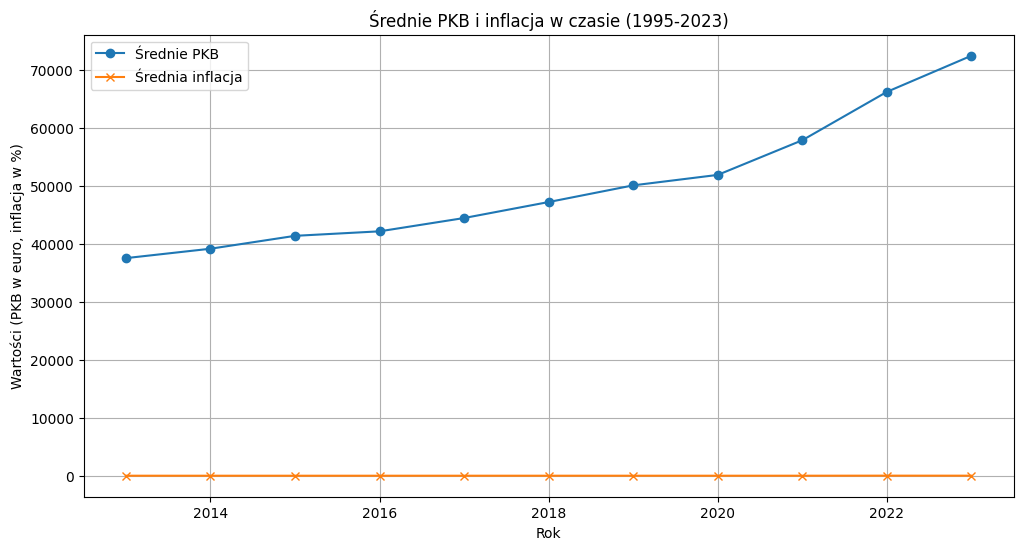

In [ ]:
import matplotlib.pyplot as plt

# analiza trendów PKB i inflacji w czasie
plt.figure(figsize=(12, 6))

# srednie roczne PKB dla wszystkich krajów
avg_gdp = data_limited.groupby("TIME_PERIOD")["GDP"].mean()
avg_inflation = data_limited.groupby("TIME_PERIOD")["Inflation"].mean()

# wykres PKB
plt.plot(avg_gdp.index, avg_gdp.values, label="Średnie PKB", marker='o')
# wykres Inflacji
plt.plot(avg_inflation.index, avg_inflation.values, label="Średnia inflacja", marker='x')

plt.title("Średnie PKB i inflacja w czasie (1995-2023)")
plt.xlabel("Rok")
plt.ylabel("Wartości (PKB w euro, inflacja w %)")
plt.legend()
plt.grid()
plt.show()


Powyższy wykres pokazuje średnie wartości PKB oraz inflacji w czasie (dla wszystkich krajów łącznie). Inflacja na 0 przez brakujace dane.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# przygotowanie zmiennych niezależnych (Inflacja) i zależnych (PKB)
X = data_limited[['Inflation']]
y = data_limited['GDP']

# train i test 80/20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# standaryzacja
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# rozmiar zbioru
train_test_split_info = {
    "Rozmiar zbioru treningowego": X_train.shape[0],
    "Rozmiar zbioru testowego": X_test.shape[0]
}

train_test_split_info


{'Rozmiar zbioru treningowego': 7600, 'Rozmiar zbioru testowego': 1900}

## Implementacja modelu
Na początek wykorzystamy Random Forest, który pozwala na uchwycenie nieliniowych relacji w danych.

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)

# predykcja
y_pred = rf_model.predict(X_test_scaled)

# ocena modelu
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

model_evaluation = {
    "Mean Squared Error (MSE)": mse,
    "R² Score": r2
}

model_evaluation


{'Mean Squared Error (MSE)': 189055874066.84802,
 'R² Score': -0.025525266350005404}

Model Random Forest wykazuje słabe dopasowanie do danych z inflacją jako jedyną cechą.

Bardzo wysoka wartość MSE wskazuje na duże błędy predykcji.

Wynik ujemny (-0.03), co oznacza, że model jest mniej skuteczny niż średnia z danych. Jedna cecha (inflacja) to zbyt mało, aby przewidywać zmiany PKB. Próba rozszerzenia projektu o dodatkowe wskaźniki.

In [ ]:
# sprawdzenie unikalnych wartości w kolumnie 'na_item' (rodzaj danych ekonomicznych)
unique_na_items = data_pkb['na_item'].unique()

# wyświetlenie unikalnych typów wskaźników ekonomicznych dostępnych w danych PKB
unique_na_items


array(['Gross domestic product at market prices',
       'Final consumption expenditure',
       'Individual consumption expenditure of general government',
       'Collective consumption expenditure of general government',
       'Final consumption expenditure of general government'],
      dtype=object)

## Dodatkowe wskaźniki makroekonomiczne

W danych PKB znajdują się następujące dodatkowe wskaźniki makroekonomiczne:

Final consumption expenditure – Całkowite wydatki konsumpcyjne

Individual consumption expenditure of general government – Indywidualne wydatki konsumpcyjne sektora rządowego

Collective consumption expenditure of general government – Zbiorowe wydatki konsumpcyjne sektora rządowego

Final consumption expenditure of general government – Całkowite wydatki sektora rządowego

Czas na dodanie tych wskaźników do modelu:

In [ ]:
# przekształcenie danych PKB - podział na cechy według 'na_item'
data_pkb_pivot = data_pkb.pivot_table(
    index=['geo', 'TIME_PERIOD'],
    columns='na_item',
    values='OBS_VALUE'
).reset_index()

# połączenie PKB z inflacją
data_extended = pd.merge(data_pkb_pivot, data_inflacja_filtered, on=['geo', 'TIME_PERIOD'], how='left')

# sprawdzenie braków w rozszerzonym zbiorze
missing_data_extended = data_extended.isnull().sum()

# podgląd
data_extended_head = data_extended.head()

missing_data_extended, data_extended_head


(geo                                                           0
 TIME_PERIOD                                                   0
 Collective consumption expenditure of general government     22
 Final consumption expenditure                                10
 Final consumption expenditure of general government          10
 Gross domestic product at market prices                       0
 Individual consumption expenditure of general government     22
 Inflation                                                   675
 dtype: int64,
        geo  TIME_PERIOD  \
 0  Albania         1995   
 1  Albania         1996   
 2  Albania         1997   
 3  Albania         1998   
 4  Albania         1999   
 
    Collective consumption expenditure of general government  \
 0                                           3.700000          
 1                                        2141.233333          
 2                                        1459.560000          
 3                                     

In [ ]:
# uzupełnianie brakujących danych metodą interpolacji (dla każdej kolumny niezależnie)
data_extended_filled = data_extended.interpolate(method='linear', limit_direction='both', axis=0)

# sprawdzenie, czy są braki
missing_data_after_filling = data_extended_filled.isnull().sum()


data_extended_filled_head = data_extended_filled.head()

missing_data_after_filling, data_extended_filled_head


<ipython-input-13-e6ce5afa8445>:2: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  data_extended_filled = data_extended.interpolate(method='linear', limit_direction='both', axis=0)


(geo                                                         0
 TIME_PERIOD                                                 0
 Collective consumption expenditure of general government    0
 Final consumption expenditure                               0
 Final consumption expenditure of general government         0
 Gross domestic product at market prices                     0
 Individual consumption expenditure of general government    0
 Inflation                                                   0
 dtype: int64,
        geo  TIME_PERIOD  \
 0  Albania         1995   
 1  Albania         1996   
 2  Albania         1997   
 3  Albania         1998   
 4  Albania         1999   
 
    Collective consumption expenditure of general government  \
 0                                           3.700000          
 1                                        2141.233333          
 2                                        1459.560000          
 3                                        1709.220000  

## Budowa modelu Random Forest z rozszerzonym zestawem cech

Brakujące dane zostały uzupełnione metodą interpolacji, a w zbiorze nie występują już braki. Dane są teraz gotowe do modelowania

In [ ]:
# przygotowanie
X = data_extended_filled.drop(columns=['geo', 'TIME_PERIOD', 'Gross domestic product at market prices'])
y = data_extended_filled['Gross domestic product at market prices']

# podział na zbiór treningowy i testowy
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# skalowanie
X_scaler = StandardScaler()
X_train_scaled = X_scaler.fit_transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

# budowa
rf_model_extended = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model_extended.fit(X_train_scaled, y_train)

# predykcja
y_pred_extended = rf_model_extended.predict(X_test_scaled)

# ocena
mse_extended = mean_squared_error(y_test, y_pred_extended)
r2_extended = r2_score(y_test, y_pred_extended)

model_extended_evaluation = {
    "Mean Squared Error (MSE)": mse_extended,
    "R² Score": r2_extended
}

model_extended_evaluation


{'Mean Squared Error (MSE)': 568457197.9843732, 'R² Score': 0.9911395102549241}

Model Random Forest z rozszerzonym zestawem cech osiągnął bardzo dobre wyniki:

Mean Squared Error (MSE): 568,457,198 (znacznie niższe niż wcześniej).
R² Score: 0.991, co oznacza, że model wyjaśnia 99.1% wariancji danych.

To potwierdza, że dodanie nowych cech znacząco poprawiło skuteczność modelu.

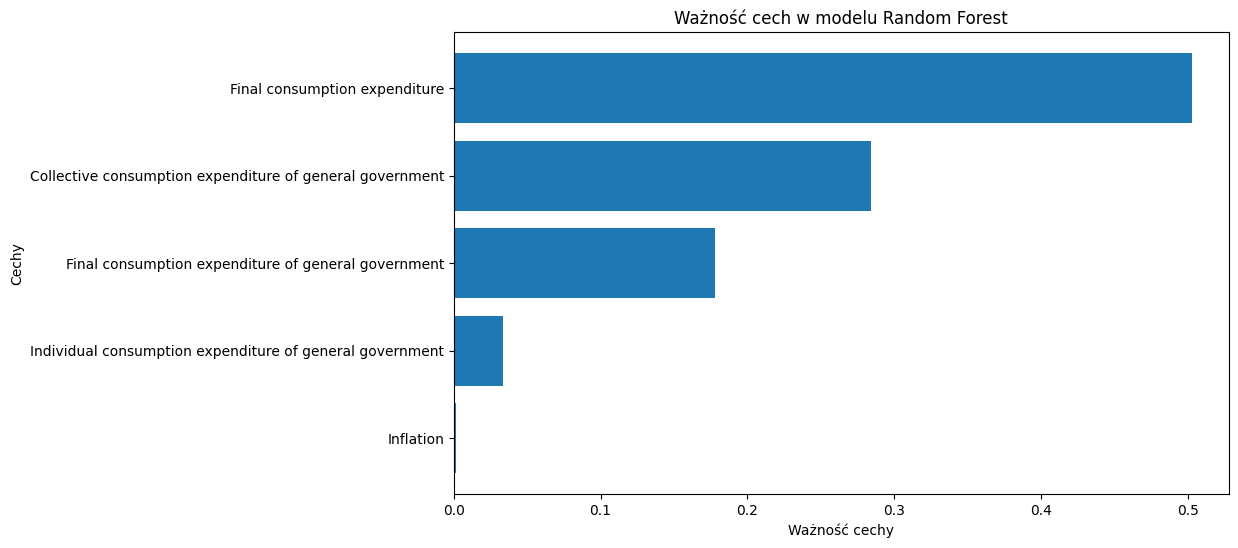

,Feature,Importance
0,Final consumption expenditure,0.502630
1,Collective consumption expenditure of general ...,0.284396
2,Final consumption expenditure of general gover...,0.178106
3,Individual consumption expenditure of general ...,0.033364
4,Inflation,0.001505


In [ ]:
# analiza znaczenia cech (feature importance)
importances = rf_model_extended.feature_importances_
feature_names = X.columns

# tworzenie DataFrame z wynikami ważności cech
feature_importance_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

# wyświetlenie wyników
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df["Feature"], feature_importance_df["Importance"])
plt.xlabel("Ważność cechy")
plt.ylabel("Cechy")
plt.title("Ważność cech w modelu Random Forest")
plt.gca().invert_yaxis()
plt.show()

feature_importance_df.reset_index(drop=True)


Inflacja ma bardzo małe znaczenie w modelu (0.15%), co wskazuje na niski bezpośredni związek z PKB w tym zestawie danych.

## Skrypt do przeprowadzenia prognoz

Ten kod pozwala użytkownikowi wybrać kraj oraz zakres lat za pomocą interfejsu graficznego (np. w Google Colab). Po kliknięciu przycisku "Przeprowadź prognozę", generowana jest prognoza PKB dla wybranego kraju i okresu.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import ipywidgets as widgets
from IPython.display import display

# przygotowanie danych
data = data_extended_filled.copy()
data['TIME_PERIOD'] = data['TIME_PERIOD'].astype(int)

# standaryzacja PKB
gdp_scaler = StandardScaler()
data['Gross domestic product at market prices'] = gdp_scaler.fit_transform(data[['Gross domestic product at market prices']])

# funkcja do przewidywania PKB dla wybranego kraju
def predict_gdp(country, start_year=2024, end_year=2034):
    # filtracja danych dla wybranego kraju
    country_data = data[data['geo'] == country]
    X = country_data.drop(columns=['geo', 'TIME_PERIOD', 'Gross domestic product at market prices'])
    y = country_data['Gross domestic product at market prices']

    # skalowanie danych
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # trenowanie modelu
    rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
    rf_model.fit(X_scaled, y)

    # tworzenie danych dla prognoz
    future_years = list(range(start_year, end_year + 1))
    future_data = pd.DataFrame({
        'Final consumption expenditure': np.linspace(X['Final consumption expenditure'].iloc[-1], X['Final consumption expenditure'].iloc[-1] * 1.1, len(future_years)),
        'Collective consumption expenditure of general government': np.linspace(X['Collective consumption expenditure of general government'].iloc[-1], X['Collective consumption expenditure of general government'].iloc[-1] * 1.1, len(future_years)),
        'Final consumption expenditure of general government': np.linspace(X['Final consumption expenditure of general government'].iloc[-1], X['Final consumption expenditure of general government'].iloc[-1] * 1.1, len(future_years)),
        'Individual consumption expenditure of general government': np.linspace(X['Individual consumption expenditure of general government'].iloc[-1], X['Individual consumption expenditure of general government'].iloc[-1] * 1.1, len(future_years)),
        'Inflation': np.linspace(X['Inflation'].iloc[-1], X['Inflation'].iloc[-1] * 1.05, len(future_years))
    })

    # ustawienie tej samej kolejności cech co podczas trenowania modelu
    future_data = future_data[X.columns]

    # skalowanie danych
    future_X_scaled = scaler.transform(future_data)

    # predykcja
    predictions = rf_model.predict(future_X_scaled)

    predictions_original_scale = gdp_scaler.inverse_transform(predictions.reshape(-1, 1)).flatten()

    # wizualizacja
    plt.figure(figsize=(10, 6))
    plt.plot(country_data['TIME_PERIOD'], gdp_scaler.inverse_transform(y.values.reshape(-1, 1)), label="Rzeczywiste PKB (mln EUR)", marker='o')
    plt.plot(future_years, predictions_original_scale, label="Prognozowane PKB (mln EUR)", marker='x')
    plt.title(f"Prognoza PKB dla kraju: {country} ({start_year}-{end_year})")
    plt.xlabel("Rok")
    plt.ylabel("PKB (mln EUR)")
    plt.legend()
    plt.grid()
    plt.show()

# tworzenie interfejsu użytkownika
country_dropdown = widgets.Dropdown(
    options=data['geo'].unique(),
    description='Kraj:',
    disabled=False
)

year_range = widgets.IntRangeSlider(
    value=[2024, 2034],
    min=2024,
    max=2040,
    step=1,
    description='Zakres lat:',
    continuous_update=False
)

predict_button = widgets.Button(
    description="Przeprowadź prognozę",
    button_style='success'
)

output = widgets.Output()

def on_predict_button_click(b):
    with output:
        output.clear_output()
        selected_country = country_dropdown.value
        start_year, end_year = year_range.value
        predict_gdp(selected_country, start_year, end_year)

predict_button.on_click(on_predict_button_click)

# wyświetlenie interfejsu użytkownika
ui = widgets.VBox([country_dropdown, year_range, predict_button, output])
display(ui)


Dodałem standaryzację PKB oraz przywracanie jego wartości do oryginalnej skali (w milionach euro) na potrzeby wizualizacji i predykcji. Skrypt teraz wyświetla wyniki w jednostkach "mln EUR"

## Podsumowanie

Na zakończenie projektu prognozowania PKB na podstawie wskaźników makroekonomicznych można wyciągnąć następujące wnioski:
- Model Random Forest osiągnął bardzo wysokie dopasowanie do danych historycznych (R² ~ 0.99), co oznacza, że dobrze odwzorowuje relacje między zmiennymi wejściowymi (wskaźnikami makroekonomicznymi) a PKB
- Dodanie większej liczby wskaźników, takich jak wydatki konsumpcyjne czy inflacja, znacząco poprawiło skuteczność modelu w porównaniu z użyciem samej inflacji

Final consumption expenditure (całkowite wydatki konsumpcyjne) to najważniejszy wskaźnik w przewidywaniu PKB. Odpowiada za ponad 50% wpływu na prognozy modelu.

Inflacja, wbrew intuicji, okazała się mieć niewielki wpływ na prognozy PKB. Być może jej rola jest bardziej istotna w połączeniu z innymi wskaźnikami lub w innych kontekstach ekonomicznych.

### Problemy i ograniczenia:

**Braki danych:** Duża liczba brakujących wartości wymagała interpolacji, co może wpływać na dokładność prognoz.

**Ograniczenie do danych historycznych:** Model bazuje wyłącznie na przeszłych danych, co może nie uwzględniać nieprzewidzianych zmian, takich jak kryzysy ekonomiczne czy pandemie.

### *Słowo końcowe:*
Projekt pokazuje, że analiza wskaźników makroekonomicznych pozwala skutecznie prognozować PKB. Jednak, aby model miał większe zastosowanie praktyczne, warto go wzbogacić o dodatkowe dane i zaawansowane techniki analizy. To solidna baza, którą można rozbudować w bardziej kompleksowe narzędzie prognozowania gospodarki.